Converting MACA Data for Envision and SWAT Models - AWR
===============================

Evan Linde, Oklahoma State University, July 2018

# Introduction

This is a record of the process we followed to make data from the [MACAv2-METDATA](https://climate.northwestknowledge.net/MACA/MACAproducts.php#MACAproductcomparison) and [METDATA](https://climate.northwestknowledge.net/METDATA/) datasets usable in [Envision](http://envision.bioe.orst.edu/) and [SWAT](http://swat.tamu.edu/) models. Large portions of this process are virtually identical to the [procedure we used in Fall 2017](https://evanlinde.github.io/MACA/MACA_to_Envision_SWAT.html) to convert data for the Cimarron and Kiamichi study areas.

Unlike what we did last fall (where we only looked at years 2021-2099 from MACAv2-METDATA), we will be using the entire "future" (2006-2099) subset of MACAv2-METDATA.

Here we will be working on the combined drainage basin for the Arkansas, White, and Red (AWR) rivers (region 11 from the [USGS Hydrological Unit Map](https://water.usgs.gov/GIS/regions.html)) subdivided into HUC10 polygons.

The data we want: 
* METDATA (historical/observational) from beginning (1979) through present
* MACAv2-METDATA ("future"/model-predicted, 2006-2099)

This document may frequently refer to our work from Fall 2017 and will only show modified scripts. Fuller explanation of most steps can be found in the Fall 2017 documentation.

## Acknowledgement and Disclaimer

Computation for this project was performed on TIGER, the research "cloud" at the Oklahoma State University [High Performance Computing Center](http://hpcc.okstate.edu).

This material is based on work supported by the National Science Foundation under Grant No. [OIA-1301789](https://www.nsf.gov/awardsearch/showAward?AWD_ID=1301789). Any opinions, findings, and conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the National Science Foundation or Oklahoma State Regents for Higher Education.

# MACAv2-METDATA

## Downloading

Create the script `download3.sh` to download earlier "future" year sets that we didn't use before (i.e. 2006-2020). (This is basically identical to the previous download scripts, but with different values in the `YEAR_BLOCKS` array.)


**`download3.sh`**

```bash
#!/bin/bash
#
# Download the 2006-2020 "future" data from MACAv2-METDATA
#

MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CCSM4" "CNRM-CM5" 
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" 
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" 
    "MIROC-ESM" "MIROC5" "MRI-CGCM3" "NorESM1-M")
YEAR_BLOCKS=("2006_2010" "2011_2015" "2016_2020")
VARS=("tasmax" "tasmin" "rhsmax" "rhsmin" "huss" "pr" "rsds" "uas" "vas")
RCPS=("rcp45" "rcp85")

base_url="https://climate.northwestknowledge.net/MACAV2METDATA/MACAV2"

echo "Begin: $(date)"
for model in ${MODELS[@]}; do
    mkdir -p "${model}"
    pushd "${model}"
    for wvar in ${VARS[@]}; do
        for block in ${YEAR_BLOCKS[@]}; do
            for rcp in ${RCPS[@]}; do
                if [[ "${model}" == "CCSM4" ]]; then
                    filename="macav2metdata_${wvar}_${model}_r6i1p1_${rcp}_${block}_CONUS_daily.nc"
                else
                    filename="macav2metdata_${wvar}_${model}_r1i1p1_${rcp}_${block}_CONUS_daily.nc"
                fi
                url="${base_url}/${model}/${filename}"
                wget ${url} &
            done
            wait
        done
    done
    popd
done
echo "End: $(date)"
```

Run the `download3.sh` script. This step saw done on TIGER's data transfer node to take advantage of the fast network connection.

```bash
cd /data/public/datasets/MACA/MACAv2-METDATA
bash download3.sh
```

From the output, we see that this took about 5 hours:
```
Begin: Sun Jun 24 21:52:32 CDT 2018
End: Mon Jun 25 02:55:17 CDT 2018
```

## Subsetting

### Find bounds (for creating geographic subsets)

Find the extents of the shapefile in ArcGIS or QGIS and use this to figure out the parameters for the subsetting commands.

	Lat: 
        31.208320 to 39.383345                     # Latitude extents from shapefile
        --> 31.1879806518555 to 39.396183013916    # Raster cell coordinates nearest to bounds
        --> 31.186 to 39.397                       # Truncate to three decimal places and round
                                                   # to make sure we get the end cells
	Lon: 
        -106.599758 to -90.143003                  # Longitude extents from shapefile
        = 253.400242 to 269.856997                 # Convert to positive degrees East
        --> 253.39421081543 to 269.852294921875    # Raster cell coordinates nearest to bounds
        --> 253.393 to 269.853                     # Truncate to three decimal places and round
                                                   # to make sure we get the end cells

Generic form for subset commands:
```
ncks -3 -d lat,31.186,39.397 -d lon,253.393,269.853 infile.nc outfile.nc
```

We create a test subset file and view it in QGIS to verify that it covers the AWR area.

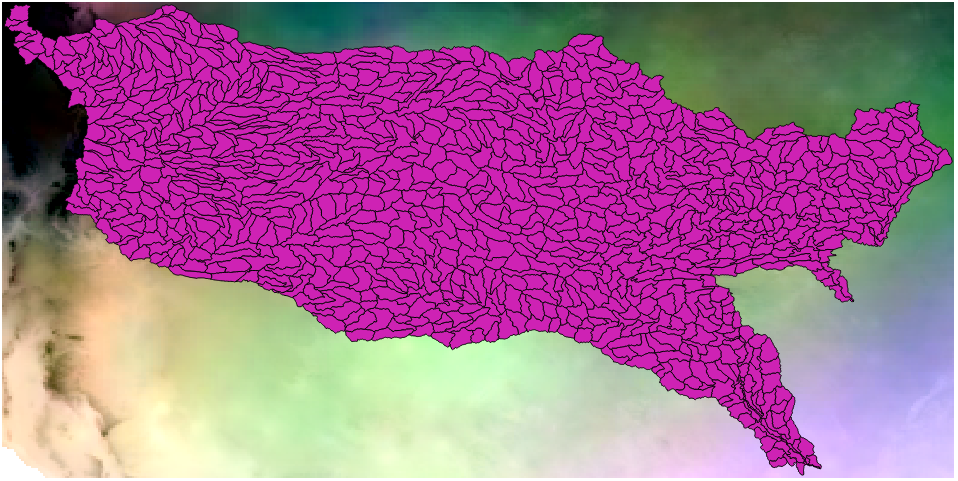

### Make file list (used for creating the subset files)

Find the files that have the years 2006 or 2016 in their names, then find the files that have the year 2011. Remove the leading "./" from the file paths.

```bash
cd /data/public/datasets/MACA/MACAv2-METDATA
find ./ -name '*20[01]6_*.nc' > file_list2.txt
find ./ -name '*2011_*.nc' >> file_list2.txt
sed -i 's:^\./::g' file_list2.txt
```

### Create subset files

Make output directories for each model. Run the subset command for every file in the old file list (years 2021-2099); then run the subset command for every file in the new file list (years 2006-2020).

```bash
cd /data/public/datasets/MACA/MACAv2-METDATA
mkdir -p ../MACAv2_Derived/AWR/{bcc-csm1-1-m,bcc-csm1-1,BNU-ESM,CanESM2,CCSM4,CNRM-CM5,CSIRO-Mk3-6-0,GFDL-ESM2G,GFDL-ESM2M,HadGEM2-CC365,HadGEM2-ES365,inmcm4,IPSL-CM5A-LR,IPSL-CM5A-MR,IPSL-CM5B-LR,MIROC-ESM-CHEM,MIROC-ESM,MIROC5,MRI-CGCM3,NorESM1-M}
time for f in $(cat file_list.txt); do ncks -3 -d lat,31.186,39.397 -d lon,253.393,269.853 ${f} ../MACAv2_Derived/AWR/${f/CONUS/AWR}; done
time for f in $(cat file_list2.txt); do ncks -3 -d lat,31.186,39.397 -d lon,253.393,269.853 ${f} ../MACAv2_Derived/AWR/${f/CONUS/AWR}; done
```

The first round (for the files we already had from last fall) took ~3634 minutes (about 2.5 days).

The seconds round ("future" files for 2006-2020) took 1327 minutes (just over 22 hours).


## Converting for Envision Models

Use the same script from last fall to convert the 2021-2099 subset files for Envision.

```bash
cd /data/public/datasets/MACA/MACAv2_Derived
time bash maca_subset_to_envision.sh AWR
```

This took 9518 minutes (about 6.6 days).

Create new script `maca_subset_to_envision2.sh` by copying `maca_subset_to_envision.sh` and setting `YEAR_BLOCKS=("2006_2010" "2011_2015" "2016_2020")`.


**`maca_subset_to_envision2.sh`**

```bash
#!/bin/bash
#
# Convert watershed-specific subsets from MACAv2-METDATA into a format usable
# in Envision. Envision-compatible netCDF files need to be in netCDF 3
# (classic) format and require the valid range for longitude in degrees east
# to be [ -180 <= x <= 180 ] rather than [ 0 <= x <= 360 ].
#
# Additionally we will need to change some units and derive new variables.
#
# Convert temperature units from Kelvins to degrees Celsius.
#
# Calculate mean daily temperatures as:
#     tasmean = mean(tasmax, tasmin)
#
# Calculate wind speed as:
#     speed = sqrt(northward_wind^2 + eastward_wind^2)
#
#
# This script requires the watershed name to be passed in as a command line
# argument and expects the watershed name to appear in the subset files
# which it will convert for Envision.
#
# 
# Evan Linde, Oklahoma State University, 2017-10-05
#
# Updated to only process years 2006-2020, 2018-06-27
#


if [ "$#" -ne 1 ]; then
    echo "This script requires the watershed directory name to be"
    echo "included as a command line argument."
    exit 1;
fi
watershed="$1" 

# Parent directories
sourcepdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}"
destpdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_Envision"


# Declare arrays for the variables we'll need to loop over
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CCSM4" "CNRM-CM5" 
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" 
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" 
    "MIROC-ESM" "MIROC5" "MRI-CGCM3" "NorESM1-M")
YEAR_BLOCKS=("2006_2010" "2011_2015" "2016_2020") 
RCPS=("rcp45" "rcp85")
# skipping "rhsmax" and "rhsmin"
# We're not actually usin the VARS array in this script
VARS=("tasmax" "tasmin" "huss" "pr" "rsds" "uas" "vas")  
# Variables used in Envision netcdf filenames. (We are using this array.)
ENVISION_VARS=("huss" "rsds" "pr" "tasmax" "tasmin" "tasmean" "wind")


# Create a temp directory
tmpdir=$(mktemp -d)

for model in ${MODELS[@]}; do

    for rcp in ${RCPS[@]}; do

        for block in ${YEAR_BLOCKS[@]}; do

            bfirst=${block:0:4}  # first year in year block
            blast=${block:5:4}   # last year in year block
            sourcedir="${sourcepdir}/${model}" # subset files for current model
            destdir="${destpdir}/${model}"     # output files for current model
            mkdir -p ${destdir}/yearly    # output dir for yearly files

            # Arbitrarily using the huss file as a template for other 
            # filenames. Most models have "r1i1p1" but at least one has 
            # "r6i1p1", so instead of a condition based on the model name, 
            # we're detecting the correct string with bash's glob expressions 
            # (i.e. the "r?i1p1" part). This could be a problem if more than 
            # one file matches the expression.
            huss_basename=$(basename $(echo ${sourcedir}/macav2metdata_huss_${model}_r?i1p1_${rcp}_${block}_${watershed}_daily.nc))
            # Prefix for yearly files; we'll add "${year}.nc" to the end 
            # when creating yearly files
            huss_y_prefix="${huss_basename/_${block}_${watershed}_daily.nc/_${watershed}_daily}"

            # Set variables for the input and output files using the huss 
            # filename as a template replacing "huss" with the target 
            # variable name
            subset_huss="${sourcedir}/${huss_basename}"
            envision_huss="${destdir}/${huss_basename}"
            subset_rsds="${sourcedir}/${huss_basename/huss/rsds}"
            envision_rsds="${destdir}/${huss_basename/huss/rsds}"
            subset_pr="${sourcedir}/${huss_basename/huss/pr}"
            envision_pr="${destdir}/${huss_basename/huss/pr}"
            subset_tasmax="${sourcedir}/${huss_basename/huss/tasmax}"
            envision_tasmax="${destdir}/${huss_basename/huss/tasmax}"
            subset_tasmin="${sourcedir}/${huss_basename/huss/tasmin}"
            envision_tasmin="${destdir}/${huss_basename/huss/tasmin}"
            envision_tasmean="${destdir}/${huss_basename/huss/tasmean}"
            subset_vas="${sourcedir}/${huss_basename/huss/vas}"
            subset_uas="${sourcedir}/${huss_basename/huss/uas}"
            envision_wind="${destdir}/${huss_basename/huss/wind}"

            # Do all the conversions
            #    subset huss --> envision huss
            #    subset rsds --> envision rsds
            #    subset pr --> envision pr
            #    subset tasmax --> envision tasmax
            #    subset tasmin --> envision tasmin
            #    envision tasmax and tasmin --> envision tasmean
            #    subset vas and uas --> envision wind
            #
            # We're not looping here since we're not doing the
            # same thing for all the variables.

            # huss (specific_humidity)
            ncap2 -3 -s 'lon=lon-360' ${subset_huss} ${envision_huss}

            # rsds (surface_downwelling_shortwave_flux_in_air)
            ncap2 -3 -s 'lon=lon-360' ${subset_rsds} ${envision_rsds}

            # pr (precipitation)
            ncap2 -3 -s 'lon=lon-360' ${subset_pr} ${envision_pr}

            # tasmax (air_temperature)
            # In addition to longitude, we're also converting temperature
            # from K to C, and then we're updating the metadata to reflect
            # this with the ncatted command.
            ncap2 -3 -s 'lon=lon-360; air_temperature=(air_temperature - 273.15)' ${subset_tasmax} ${envision_tasmax}
            ncatted -a units,air_temperature,o,char,'C' ${envision_tasmax}

            # tasmin (air_temperature)
            ncap2 -3 -s 'lon=lon-360; air_temperature=(air_temperature - 273.15)' ${subset_tasmin} ${envision_tasmin}
            ncatted -a units,air_temperature,o,char,'C' ${envision_tasmin}

            # Calculated variable: tasmean (air_temperature)
            nces -3 ${envision_tasmax} ${envision_tasmin} ${envision_tasmean}
            ncatted -a cell_methods,air_temperature,o,c,'time: mean(interval: 24 hours)' -a long_name,air_temperature,o,c,'Daily Mean Near-Surface Air Temperature' ${envision_tasmean}

            # Calculated variable: wind (wind_speed)
            # Make a temporary copy of the vas file. (It will be modified.)
            cp ${subset_vas} ${tmpdir}/vas.nc
            # Append the uas variable (eastward_wind) into the vas file
            ncks -A ${subset_uas} ${tmpdir}/vas.nc
            # Calculate wind speed. The output file from this command will have
            # three variables: northward_wind, eastward_wind, and wind_speed.
            ncap2 -s 'lon=lon-360; wind_speed=sqrt(northward_wind^2 + eastward_wind^2)' ${tmpdir}/vas.nc ${tmpdir}/wind.nc
            # Extract the wind_speed variable into its own file
            ncks -3 -v wind_speed ${tmpdir}/wind.nc ${envision_wind}
            # Get rid of temporary files
            rm ${tmpdir}/vas.nc ${tmpdir}/wind.nc
            # Update metadata. (The wind_speed variable inherited the
            # metadata from the vas variable, northward_wind.)
            ncatted -a comments,wind_speed,o,c,'Surface (10m) wind speed' -a long_name,wind_speed,o,c,'Wind Speed' -a standard_name,wind_speed,o,c,'wind_speed' ${envision_wind}

            # Split all the envision files into yearly files
            # Doing a C-style for loop here because "{${bfirst}..${blast}}"
            # doesn't work like it would with literals.
            for ((y=${bfirst}; y<=${blast}; y++)); do

                # We can conveniently loop over the variables here since 
                # we're doing the same thing for all of them.
                for ev in ${ENVISION_VARS[@]}; do

                    infile="${destdir}/${huss_basename/huss/${ev}}"
                    outfile="${destdir}/yearly/${huss_y_prefix/huss/${ev}}_${y}.nc"
                    # Year Bounds
                    # Get the first and last day of the given year in the form
                    # of "first,last" where first and last are floating point
                    # numbers representing "days since 1900-01-01".
                    yb=$(bash yearbounds.sh ${y})

                    ncks -d time,${yb} ${infile} ${outfile}

                done  # end of envision vars loop

            done  # end of years inside year block loop

        done  # end of year blocks loop

    done  # end of rcps loop

done  # end of models loop

# Cleanup: remove the temp directory we created at the beginning
rm -rf ${tmpdir}

```

Run the new script to convert the 2006-2020 subset files for Envision.

```bash
cd /data/public/datasets/MACA/MACAv2_Derived
time bash maca_subset_to_envision2.sh AWR
```

This took 2565 minutes (42.75 hours, or a little less than two days).

## Converting for SWAT Models

### Create relative humidity netCDF files

Copy `relative_humidity.sh` to `relative_humidity2.sh` and modify the new script to include years 2006-2020 (in addition to 2021-2099).


**`relative_humidity2.sh`**

```bash
#!/bin/bash
#
# Create files for mean daily relative humidity (in the ${watershed_Envision
# directory). This isn't for Envision itself, but to make data conversion
# for SWAT easier.
#
# This script requires the watershed name to be passed in as a command line
# argument.
#
# Evan Linde, Oklahoma State University, 2017-10-11
#
#
# Modified to include years 2006-2020 for the AWR study area, 2018-06-29
#
#


if [ "$#" -ne 1 ]; then
    echo "This script requires the watershed directory name to be"
    echo "included as a command line argument."
    exit 1;
fi
watershed="$1" 

# Parent directories
sourcepdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}"
destpdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_Envision"


# Declare arrays for the variables we'll need to loop over

# Excluding CCSM4 and NorESM1-M since these don't have rhsmin and rhsmax
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CNRM-CM5" 
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" 
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" 
    "MIROC-ESM" "MIROC5" "MRI-CGCM3")

YEAR_BLOCKS=("2006_2010" "2011_2015" "2016_2020" "2021_2025" "2026_2030"
    "2031_2035" "2036_2040" "2041_2045" "2046_2050" "2051_2055" 
    "2056_2060" "2061_2065" "2066_2070" "2071_2075" "2076_2080" 
    "2081_2085" "2086_2090" "2091_2095" "2096_2099")

RCPS=("rcp45" "rcp85")


# Create a temp directory
tmpdir=$(mktemp -d)

for model in ${MODELS[@]}; do

    sourcedir="${sourcepdir}/${model}"  # subset files for current model
    destdir="${destpdir}/${model}"      # output files for current model

    for rcp in ${RCPS[@]}; do

        for block in ${YEAR_BLOCKS[@]}; do

            subset_rhsmax="${sourcedir}/macav2metdata_rhsmax_${model}_r1i1p1_${rcp}_${block}_${watershed}_daily.nc"
            subset_rhsmin="${sourcedir}/macav2metdata_rhsmin_${model}_r1i1p1_${rcp}_${block}_${watershed}_daily.nc"
            envision_rhsmean="${destdir}/macav2metdata_rhsmean_${model}_r1i1p1_${rcp}_${block}_${watershed}_daily.nc"

            # Calculate mean relative humidity
            nces ${subset_rhsmax} ${subset_rhsmin} ${tmpdir}/rhsmean.nc

            # Fix longitude
            ncap2 -3 -s 'lon=lon-360' ${tmpdir}/rhsmean.nc ${envision_rhsmean}

            # Delete temp file
            rm ${tmpdir}/rhsmean.nc

            # Update metadata
            ncatted -a long_name,relative_humidity,o,c,'Surface Daily Mean Relative Humidity' -a cell_methods,relative_humidity,o,c,'time: mean(interval: 24 hours)' ${envision_rhsmean} 

        done  # end of year blocks loop

    done  # end of rcps loop

done  # end of models loop

# Cleanup: remove the temp directory we created at the beginning
rm -rf ${tmpdir}

```

Run the new relative humidity script to process the entire time series.

```bash
time bash relative_humidity2.sh AWR
```

This took 824 minutes (13.73 hours).

### Calculate sub-polygon means

Here we diverge from the process used in Fall 2017 for the Cimarron study area. In the previous process, we used data from the centroid points of the sub-polygons, but for the AWR study we were tasked to provide the area mean values.

At first, we looked at [rasterstats](https://pythonhosted.org/rasterstats/rasterstats.html) for calculating the area averages for the sub-polygons, but it isn't capable of handling the netCDF files without explicitly doing a for loop over the time steps (where it calculates the masks for the polygons each time).

The rasterstats library has an option to output the masks it produces for the polygons, but does not appear to have a way to include them in a call to the zonal_stats() function.

In our tests, each time step took around 3-4 minutes (over HUC8 polygons) with rasterstats, so calculating the polygon means for one model-rcp-variable for the entire future time series (34333 days) would take (at best) a 102999 minutes (about 71.5 days). Tests calculating the area means over HUC10 polygons for one time step took anywhere from 16:44 (1004 seconds; best time; testing against a maximum temperature file) to 23:21 (1401 seconds; worst time; testing against a precipitation file).

With 18 models, 2 RCPs, and 6 variables being used with SWAT, this means the entire dataset to be used will require (at least) **236 years** to process serially.

    1004 * 34333 * 18 * 2 * 6 = 7445591712 seconds = 86175.83 days =~ 236 years
    (seconds_per_time_step * time_steps * models * rcps * variables)

We figured that we should be able to do better than this.

By calculating and saving reusable masks for each of the HUC10 polygons we can avoid repeating one of the costlier operations in calculating zonal mean values. (This works since the raster grid is identical for all the subset and Envision netCDF files.) Further, since we can work with the entire netCDF time series in python using the [`netCDF4` library](http://unidata.github.io/netcdf4-python/) and use `numpy` vectorized operations to calculate mean values over the time series, we can expect to improve significantly upon what `rasterstats` can do.

**`make_huc_masks.py`**

```python
#
# Make a library of raster masks for the HUC10 polygons in the AWR
# subset files of MACAv2-METDATA.
#
# Evan Linde, Oklahoma State University, 2018-06-26
#

import netCDF4 as nc
import numpy as np
from cartopy.io.shapereader import Reader
import shapely.geometry as sgeom

nc_file = '/data/public/datasets/MACA/AWR-test.nc'
shp_file = 'huc10_bnd/AWR_HUC10.shp'

nc_x = 'lon'
nc_y = 'lat'
nc_var = 'air_temperature'
shp_attr = 'HUC10'

output_file = 'macav2_derived_AWR_huc10_masks.py'

# Make numpy not ellipsize ndarrays (i.e. show the whole array 
# when we print or try to get its string representation).
np.set_printoptions(threshold=np.nan)

# Open the netCDF file and read the shapefile
ncdata = nc.Dataset(nc_file, mode='r')
geo_records = [x for x in Reader(shp_file).records()]

# Empty dictionary for the masks
huc_masks = {}

# Calculate the mask for each sub-polygon
for huc in geo_records:
    huc_id = huc.attributes[shp_attr]
    #print(huc_id)
    # Create a raster-sized mask with every cell set to False
    tmp_mask = np.tile(False, (len(ncdata.variables[nc_y]), len(ncdata.variables[nc_x])))
    # Evaluate the cells within the sub-polygon's bounds. If their
    # centroid points are in the polygon, set the mask value to True.
    minx, miny, maxx, maxy = huc.geometry.bounds
    for j,y in enumerate(ncdata.variables[nc_y]):
        if y >= miny and y <= maxy:
            for i,x in enumerate(ncdata.variables[nc_x]):
                # We're looking at a raster that hasn't been converted
                # for Envision, so Western hemisphere longitudes have values
                # between 180 and 360 degrees East.
                if (x-360) >= minx and (x-360) <= maxx:
                    tmp_mask[j,i] = huc.geometry.contains(sgeom.Point(x-360, y))
    huc_masks[huc_id] = tmp_mask


# Write the masks to an output file
# The output file will be a python library that we can import in other scripts
with open(output_file, 'w') as f:
    f.write('# Masks for the HUC10 polygons in the AWR subset rasters of MACAv2-METDATA\n')
    f.write('import numpy as np\n')
    f.write('huc10_masks = {\n')
    for k in huc_masks:
        # Write each mask (dictionary entry) on a single line, getting rid
        # of unnecessary spaces and replacing True/False values with 1s and
        # 0s to save space. (This file will be large.)
        f.write("'%s': np.%s,\n"%(k, repr(huc_masks[k]).replace('\n','').replace('False','0').replace('True','1').replace(' ','')))
    f.write('}\n')
    f.close()

```

Make library of HUC masks:

```bash
python make_huc_masks.py
```

This took between 5 and 6 minutes for HUC8 (~26 MB), 10 minutes for HUC10 (~150 MB).


Create script `zonal_means.py` to use the huc10 mask library.

**`zonal_means.py`**

```python
#
# Extract data from netCDF files for use in SWAT.
#
# The netCDF files we're extracting from are the MACAv2-METDATA data with units
# converted for use with Envision and longitudes in the Western hemisphere
# converted to negative values. Since Envision and SWAT like the same units,
# we're not doing any unit conversions here like we would if extracting
# directly from the original MACAv2 netCDFs.
#
# We've also added netcdf files of daily mean relative humidity (which we're
# not using in Envision) into our Envision directories to make things easier 
# on our scripts.
#
# This script is intended to process an entire model directory. For each
# combination of climate variable and RCP, it reads all the matching files
# as a time series multi-file dataset, then loops over the set of masks
# and calculates a time series of averages over the masked cells and writes
# an output file containing the data for the masked region.
#
# This script requires two command line arguments:
# 1. input directory of netCDF files
# 2. output directory where mask subsets will be written
#
#
# Evan Linde, Oklahoma State University, 2018-07-02
#

from netCDF4 import MFDataset
import numpy as np
import sys
import os
import macav2_derived_AWR_huc10_masks as masks # dictionary variable: "huc10_masks"

# Get inputs and output locations from command line arguments
in_dir = sys.argv[1]
out_dir = sys.argv[2]


rcps = ["rcp45", "rcp85"]

# Dictionary of climate variables
# Each key is the variable name in the netcdf file name
# Each value is a list containing:
#      0. the variable name *inside* the netcdf file
#      1. string formatter for the variable (for SWAT)
clim_vars = {'pr':['precipitation','%5.1f'], 
             'rhsmean':['relative_humidity','%8.3f'],
             'rsds':['surface_downwelling_shortwave_flux_in_air','%8.3f'], 
             'tasmax':['air_temperature','%5.1f'], 
             'tasmin':['air_temperature','%5.1f'], 
             'wind':['wind_speed','%8.3f']}


for rcp in rcps:
    for fvar in clim_vars.keys():
        ncvar = clim_vars[fvar][0]
        varfmt = clim_vars[fvar][1]

        # expression for base filename of input file containing both
        # string formatters (e.g. '%s') and wildcards for globbing
        infilename_expr = 'macav2metdata_%s_*_r?i1p1_%s_*.nc'

        # replace the string formatters with values
        infilename_glob = infilename_expr % (fvar, rcp)

        # combine the input directory with filename glob for a full path glob
        infile_glob = os.path.join(in_dir, infilename_glob)

        # read multi-file dataset (all years for our current variable and rcp)
        mfd = MFDataset(infile_glob, aggdim='time')

        # create a variable for easier addressing/indexing
        ncdata = mfd.variables[ncvar][:]

        for huc_id, huc_mask in masks.huc10_masks.items():
            # set a distinct output directory for each huc_id
            outfiledir = os.path.join(out_dir, huc_id)

            # create the huc_id output directory (any any necessary
            # intermediate directories, like "mkdir -p" in bash)
            os.makedirs(outfiledir, exist_ok=True)

            # base name for output file
            outfilename = '%s_%s_%s.txt' % (huc_id, fvar, rcp)

            # full path for output file
            outfile = os.path.join(outfiledir, outfilename)

            # time series of area means for the cells matching the mask
            outdata = ncdata[:,huc_mask].mean(axis=1)

            # save the point data to a file
            # using '%.3f' instead of varfmt to match example files I was sent
            np.savetxt(outfile, outdata, fmt='%.3f', newline='\r\n', header='20060101', comments='')
            
```

Temporarily edit the script so that we only process one variable (tasmax) and run a test:
```bash
time python zonal_means.py AWR_Envision/inmcm4 AWR-test-SWAT
```

This took 21 minutes to calculate the polygon means for the entire time series for one variable and both RCPs. So we estimate that it should take roughly 126 minutes (slightly over two hours) to completely process one model serially and slightly under two days to complete the entire dataset.

The script consumed a large amount of memory at certain steps, particularly reading the netCDF multi-file dataset and aliasing?/copying? the entire dataset into another variable. We increased the memory allocation of the jupyter VM to 64 GB; this, in addition to the 16 GB of disk space allocated to swap was sufficient to handle the high-memory steps. The inner loop where all our calculations occurred mostly used around 24 GB of RAM (close to the combined size of the netCDF files).

Make a bash "script" defining an array of the HUC10 IDs for sourcing.
```bash
awk -F ': ' 'NF==2{sep=((FNR-2)%5==1 ? "\n    ": " ");dirs=dirs""$1""sep} END{print "huc_ids=("dirs")"}' macav2_derived_AWR_huc10_masks.py > huc10_ids.sh
```

Make a file containing columns for the year (starting with 2006 = year 1) and day of year for all the days of the "future" dataset.
```bash
echo "20060101" > year_days_2006_2099.txt
for d in {0..34332}; do date --date="2006-01-01 +${d} days" +"%Y%t%j"; done | awk '{printf("%d\t%d\n",$1-2005,$2)}' >> year_days_2006_2099.txt
```

Create `zonal_envision_to_swat.sh` to run `zonal_means.py` for all models and combine variable sets into a single file for each huc_id-model-rcp combination.

**`zonal_envision_to_swat.sh`**

```bash
#!/bin/bash
#
# This script is a wrapper for the python script zonal_means.py which 
# processes a single model directory. The purpose of this script is to loop
# over the models and create output directories for the python script.
#
# This script requires the watershed name to be passed in as a command
# line argument.
#

watershed="$1"

# Skipping CCSM4 and NorESM1-M since these don't have relative humidity
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CNRM-CM5" 
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" 
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" 
    "MIROC-ESM" "MIROC5" "MRI-CGCM3")

RCPS=("rcp45" "rcp85")

sourcepdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_Envision"
destpdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_SWAT"

# get the huc_ids array
source huc10_ids.sh

# Set PATH variable so that we use the Anaconda python distribution
PATH=/opt/anaconda3/bin:$PATH

for model in ${MODELS[@]}; do
    sourcedir="${sourcepdir}/${model}"
    destdir="${destpdir}/${model}"
    mkdir -p ${destdir}
    python zonal_means.py ${sourcedir} ${destdir}

    # The point_subset.py script creates files with a single variable
    # SWAT wants a two-column file with tasmax and tasmin separated by commas
    for h in ${huc_ids[@]}; do
        for rcp in ${RCPS[@]}; do
            paste year_days_2006_2099.txt ${destdir}/${h}/${h}_{tasmin,tasmax,pr,rhsmean,rsds,wind}_${rcp}.txt | awk 'NR>1{printf("%d\t%d\t%.1f\t%.1f\t%.2f\t%.2f\t%.2f\t%.2f\n",$1,$2,$3,$4,$5,$6,$7,$8)}' > ${destdir}/${h}/${h}_${model}_${rcp}_SWAT.txt
        done  # end rcp loop
    done  # end huc_id loop
done  # end model loop
```

Finally, create the SWAT files:
```bash
time bash zonal_envision_to_swat.sh AWR
```

This completed in slightly under 1808 minutes -- just over 30 hours. (This is 68635.62 times as fast as the 236 year estimate to complete with rasterstats.)


Forgot to include mean temperature. Create new scripts `zonal_means_tasmean.py` and `zonal_envision_to_swat_tasmean.sh` to create the single-column files for mean temperature.

**`zonal_means_tasmean.py`**

```python
#
# Extract data from netCDF files for use in SWAT.
#
# The netCDF files we're extracting from are the MACAv2-METDATA data with units
# converted for use with Envision and longitudes in the Western hemisphere
# converted to negative values. Since Envision and SWAT like the same units,
# we're not doing any unit conversions here like we would if extracting
# directly from the original MACAv2 netCDFs.
#
# We've also added netcdf files of daily mean relative humidity (which we're
# not using in Envision) into our Envision directories to make things easier
# on our scripts.
#
# This script is intended to process an entire model directory. For each
# combination of climate variable and RCP, it reads all the matching files
# as a time series multi-file dataset, then loops over the set of points
# we want to use as SWAT weather stations and writes an output file containing
# the data for that point.
#
# This script is reduced to only process mean temperature.
#
# This script requires two command line arguments:
# 1. input directory of netCDF files
# 2. output directory where point subsets will be written (must already exist)
#
#
# Evan Linde, Oklahoma State University, 2018-07-13
#

from netCDF4 import MFDataset
import numpy as np
import sys
import os
import macav2_derived_AWR_huc10_masks as masks # dictionary variable: "huc10_masks"

# Get inputs and output locations from command line arguments
in_dir = sys.argv[1]
out_dir = sys.argv[2]


rcps = ["rcp45", "rcp85"]

# Dictionary of climate variables
# Each key is the variable name in the netcdf file name
# Each value is a list containing:
#      0. the variable name *inside* the netcdf file
#      1. string formatter for the variable (for SWAT)
clim_vars = {'tasmean':['air_temperature','%5.1f']}

for rcp in rcps:
    for fvar in clim_vars.keys():
        ncvar = clim_vars[fvar][0]
        varfmt = clim_vars[fvar][1]

        # expression for base filename of input file containing both
        # string formatters (e.g. '%s') and wildcards for globbing
        infilename_expr = 'macav2metdata_%s_*_r?i1p1_%s_*.nc'

        # replace the string formatters with values
        infilename_glob = infilename_expr % (fvar, rcp)

        # combine the input directory with filename glob for a full path glob
        infile_glob = os.path.join(in_dir, infilename_glob)

        # read multi-file dataset (all years for our current variable and rcp)
        mfd = MFDataset(infile_glob, aggdim='time')

        # create a variable for easier addressing/indexing
        ncdata = mfd.variables[ncvar][:]

        for huc_id, huc_mask in masks.huc10_masks.items():
            # set a distinct output directory for each huc_id
            outfiledir = os.path.join(out_dir, huc_id)

            # create the huc_id output directory (any any necessary
            # intermediate directories, like "mkdir -p" in bash)
            os.makedirs(outfiledir, exist_ok=True)

            # base name for output file
            outfilename = '%s_%s_%s.txt' % (huc_id, fvar, rcp)

            # full path for output file
            outfile = os.path.join(outfiledir, outfilename)

            # time series of area means for the cells matching the mask
            outdata = ncdata[:,huc_mask].mean(axis=1)

            # save the point data to a file
            # using '%.3f' instead of varfmt to match example files I was sent
            np.savetxt(outfile, outdata, fmt='%.3f', newline='\r\n', header='20060101', comments='')

```

**`zonal_envision_to_swat_tasmean.sh`**

```bash
#!/bin/bash
#
# This script is a wrapper for the python script zonal_means_tasmean.py which
# processes a single model directory. The purpose of this script is to loop
# over the models and create output directories for the python script.
#
# This script requires the watershed name to be passed in as a command
# line argument.
#

watershed="$1"

# Skipping CCSM4 and NorESM1-M since these don't have relative humidity
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CNRM-CM5"
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365"
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM"
    "MIROC-ESM" "MIROC5" "MRI-CGCM3")

RCPS=("rcp45" "rcp85")

sourcepdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_Envision"
destpdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_SWAT"

## get the huc_ids array
#source huc10_ids.sh

# Set PATH variable so that we use the Anaconda python distribution
PATH=/opt/anaconda3/bin:$PATH

for model in ${MODELS[@]}; do
    sourcedir="${sourcepdir}/${model}"
    destdir="${destpdir}/${model}"
    mkdir -p ${destdir}
    python zonal_means_tasmean.py ${sourcedir} ${destdir}

    ## The point_subset.py script creates files with a single variable
    ## SWAT wants a two-column file with tasmax and tasmin separated by commas
    #for h in ${huc_ids[@]}; do
    #    for rcp in ${RCPS[@]}; do
    #        paste year_days_2006_2099.txt ${destdir}/${h}/${h}_{tasmin,tasmax,pr,rhsmean,rsds,wind}_${rcp}.txt | awk 'NR>1{printf("%d\t%d\t%.1f\t%.1f\t%.2f\t%.2f\t%.2f\t%.2f\n",$1,$2,$3,$4,$5,$6,$7,$8)}' > ${destdir}/${h}/${h}_${model}_${rcp}_SWAT.txt
    #    done  # end rcp loop
    #done  # end huc_id loop
done  # end model loop
```

Create the mean temperature files:

```bash
cd /data/public/datasets/MACA/MACAv2_Derived/
time bash zonal_envision_to_swat_tasmean.sh AWR
```

This took 394 minutes (6.56 hours).

Create new script `maca_swat2_AWR.sh` to combine all the single-column files including mean temperature into a multi-column file. (Copy from `maca_swat2.sh` and modify.)


**`maca_swat2_AWR.sh`**

```bash
#!/bin/bash
#
# This script combines the single-column files of SWAT input variables 
# into one multi-column file.
#
# This script requires the watershed name to be passed in as a command
# line argument.
#

watershed="$1"

# Skipping CCSM4 and NorESM1-M since these don't have relative humidity
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CNRM-CM5" 
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365" 
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM" 
    "MIROC-ESM" "MIROC5" "MRI-CGCM3")

RCPS=("rcp45" "rcp85")

sourcepdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_SWAT"
destpdir="/data/public/datasets/MACA/MACAv2_Derived/${watershed}_SWAT2"

# get the huc_ids array
source huc10_ids.sh

for model in ${MODELS[@]}; do
    sourcedir="${sourcepdir}/${model}"
    destdir="${destpdir}/${model}"
    mkdir -p ${destdir}

    # The point_subset.py script creates files with a single variable
    # SWAT wants a two-column file with tasmax and tasmin separated by commas
    for h in ${huc_ids[@]}; do
        for rcp in ${RCPS[@]}; do
            paste year_days_2006_2099.txt ${sourcedir}/${h}/${h}_{tasmin,tasmax,tasmean,pr,rhsmean,rsds,wind}_${rcp}.txt | awk 'NR>1{printf("%d\t%d\t%.1f\t%.1f\t%.1f\t%.2f\t%.2f\t%.2f\t%.2f\n",$1,$2,$3,$4,$5,$6,$7,$8,$9)}' > ${destdir}/${h}_${model}_${rcp}_SWAT.txt
        done  # end rcp loop
    done  # end huc_id loop
done  # end model loop
```

Combine the SWAT files:
```bash
time bash maca_swat2_AWR.sh AWR
```

This took 281 minutes (4.68 hours).

# METDATA

## Downloading

Create `download2.sh` to download complete metdata files for 2017 (since our existing files don't contain the entire year) and the partial files for 2018 (up to current date, 2017-07-02).

**`download2.sh`**
```bash
#!/bin/bash

for v in {pr,sph,srad,tmmx,tmmn,rmax,rmin,vs}; do
    #[[ -f ${v}_2017.nc ]] && rm ${v}_2017.nc
    #for y in {2017..2018}; do
    for y in {1979..2016}; do
        url="http://www.northwestknowledge.net/metdata/data/${v}_${y}.nc"
        wget ${url}
    done
done
```

Run the download script on TIGER's data transfer node to take advantage of the fast network connection.
```bash
cd /data/public/datasets/MACA/METDATA/
bash download2.sh
```

This took about three minutes.

After running into a problem later in the process, we noticed that the grid on the newly downloaded 2017 and 2018 files is slightly different from the older files, so to keep things consistent we modified `download2.sh` to get years 1979 to 2016, deleted the old files for those years, and re-ran `download2.sh`.

```bash
cd /data/public/datasets/MACA/METDATA/
rm *_{1979..2016}.nc
time bash download2.sh
```

This took just under 85 minutes.


## Subsetting

### Finding Coordinates

Recall the latitude and longitude extents from the shapefile:

	Lat: 
        31.208320 to 39.383345           # Latitude bounds from shapefile
        --> 31.1916666666667 to 39.4     # Raster cell coordinates nearest to the bounds
        --> 31.19 to 39.41               # Truncate to three decimal places and round up or 
                                         # down by 0.001 to make sure we get the end cells
	Lon: 
        -106.599758 to -90.143003                    # Latitude bounds from shapefile
        --> -106.599999966667 to -90.1416666333333   # Raster cell coordinates nearest to the bounds
        --> -106.60 to -90.14            # Truncate to three decimal places and round up or 
                                         # down by 0.001 to make sure we get the end cells
 
 Generic form for subset commands:
 ```
 ncks -3 -d lat,31.19,39.41 -d lon,-106.60,-90.14 infile.nc outfile.nc
 ```
 
 We create a test subset file and view it in QGIS to verify that it covers the AWR area.

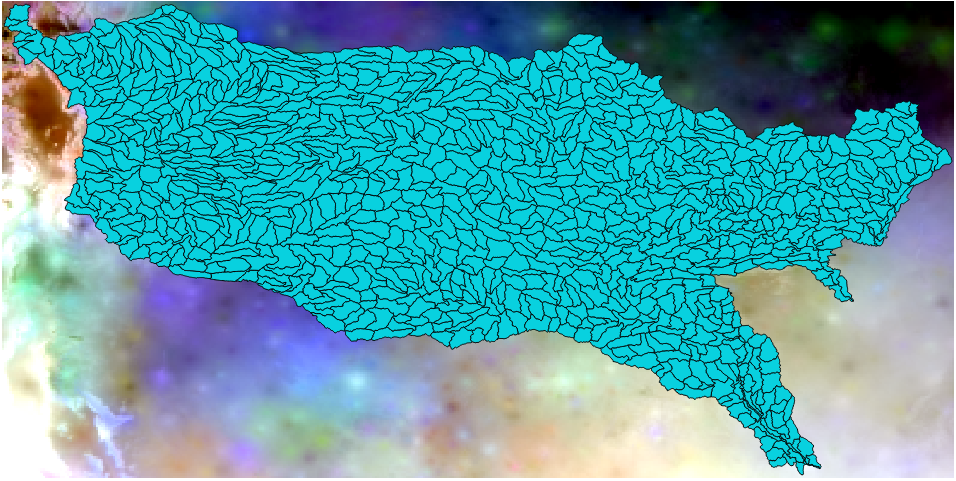

### Create subset files

Create the AWR subset files:

```bash
cd /data/public/datasets/METDATA_Derived
mkdir AWR
for v in {pr,sph,srad,tmmx,tmmn,rmax,rmin,vs}; do
    for y in {1979..2018}; do
        filename="${v}_${y}.nc"
        ncks -3 -d lat,31.19,39.41 -d lon,-106.60,-90.14 ../METDATA/${filename} AWR/${filename}
    done
done
```

This finished in 69 minutes.

## Converting for Envision Models

Create script `metdata_subset_to_envision2.sh`. (Copy `metdata_subset_to_envision.sh` and update it to include year 2018.)

**`metdata_subset_to_envision2.sh`**

```bash
#!/bin/bash
#
# Convert watershed-specific subsets from METDATA into a format usable
# in Envision. Envision-compatible netCDF files need to be in netCDF 3
# (classic) format and require dimension ordering like (time, lat, lon)
# instead of (time, lon, lat).
#
# Also convert relative humidity (for later conversion to SWAT) even though
# it's not needed for Envision.
#
# Additionally we will need to change some units and derive new variables.
#
# Convert temperature units from Kelvins to degrees Celsius.
#
# Calculate mean daily temperatures as:
#     tasmean = mean(tasmax, tasmin)
#
#
# This script requires the watershed name to be passed in as a command line
# argument.
#
#
# Evan Linde, Oklahoma State University, 2017-10-09
#
# 2018-07-03 -- updated year set to include 2018
#


if [ "$#" -ne 1 ]; then
    echo "This script requires the watershed directory name to be"
    echo "included as a command line argument."
    exit 1;
fi
watershed="$1"

# directories
sourcedir="/data/public/datasets/MACA/METDATA_Derived/${watershed}"
destdir="/data/public/datasets/MACA/METDATA_Derived/${watershed}_Envision"
mkdir -p ${destdir}


# Create a temp directory
tmpdir=$(mktemp -d)

for year in {1979..2018}; do

    # Only correct dimensions for these variables
    for var in {pr,sph,srad,vs}; do
        infile="${sourcedir}/${var}_${year}.nc"
        outfile="${destdir}/${var}_${year}.nc"
        ncpdq -3 -a lat,lon ${infile} ${outfile}
    done

    # Rename precipitation variable so it will match the MACAv2 data
    # This isn't strictly necessary for Envision but makes it easier
    # to use both datasets.
    ncrename -v precipitation_amount,precipitation ${destdir}/pr_${year}.nc

    # Convert temperatures from Kelvins to degrees Celsius
    # and re-order dimensions
    for var in tmmn tmmx; do
        infile="${sourcedir}/${var}_${year}.nc"
        outfile="${destdir}/${var}_${year}.nc"
        tmpfile="${tmpdir}/${var}_${year}.nc"
        ncap2 -s 'air_temperature=(air_temperature - 273.15)' ${infile} ${tmpfile}
        ncatted -a units,air_temperature,o,char,'C' ${tmpfile}
        ncpdq -3 -a lat,lon ${tmpfile} ${outfile}
        rm ${tmpfile}
    done

    # Create the mean temperature file
    infiles=(${destdir}/tmm{x,n}_${year}.nc)  # array of two filenames
    outfile="${destdir}/tmmean_${year}.nc"
    nces ${infiles[@]} ${outfile}
    # Update metadata
    ncatted -a description,air_temperature,o,c,'Daily Mean Temperature' ${outfile}

    # Create mean relative humidity file
    infiles=(${sourcedir}/rm{in,ax}_${year}.nc)  # array of two filenames
    outfile="${destdir}/rmean_${year}.nc"
    tmpfile="${tmpdir}/rmean_${year}.nc"
    nces ${infiles[@]} ${tmpfile}
    ncpdq -3 -a lat,lon ${tmpfile} ${outfile}
    rm ${tmpfile}
    ncatted -a description,relative_humidity,o,c,'Daily Mean Relative Humidity' -a cell_methods,relative_humidity,o,c,'time: mean(i
nterval: 24 hours)' ${outfile}

done  # end of years loop

# Cleanup: remove the temp directory we created at the beginning
rm -rf ${tmpdir}

```

Create the Envision files:

```bash
time bash metdata_subset_to_envision2.sh AWR
```

This took slightly under 52 minutes.

## Converting for SWAT Models

Create script `metdata_make_huc_masks.py` to create the HUC10 mask library for METDATA.

**`metdata_make_huc_masks.py`**

```python
#
# Make a library of raster masks for the HUC10 polygons in the AWR
# subset files of METDATA.
#
# Evan Linde, Oklahoma State University, 2018-07-12
#

import netCDF4 as nc
import numpy as np
from cartopy.io.shapereader import Reader
import shapely.geometry as sgeom

nc_file = '/data/public/datasets/MACA/METDATA_Derived/AWR/tmmx_2018.nc'
shp_file = 'huc10_bnd/AWR_HUC10.shp'

nc_x = 'lon'
nc_y = 'lat'
nc_var = 'air_temperature'
shp_attr = 'HUC10'

output_file = 'metdata_derived_AWR_huc10_masks.py'

# Make numpy not ellipsize ndarrays (i.e. show the whole array 
# when we print or try to get its string representation).
np.set_printoptions(threshold=np.nan)

# Open the netCDF file and read the shapefile
ncdata = nc.Dataset(nc_file, mode='r')
geo_records = [x for x in Reader(shp_file).records()]

# Empty dictionary for the masks
huc_masks = {}

# Calculate the mask for each sub-polygon
for huc in geo_records:
    huc_id = huc.attributes[shp_attr]
    #print(huc_id)
    # Create a raster-sized mask with every cell set to False
    tmp_mask = np.tile(False, (len(ncdata.variables[nc_y]), len(ncdata.variables[nc_x])))
    # Evaluate the cells within the sub-polygon's bounds. If their
    # centroid points are in the polygon, set the mask value to True. 
    minx, miny, maxx, maxy = huc.geometry.bounds
    for j,y in enumerate(ncdata.variables[nc_y]):
        if y >= miny and y <= maxy:
            for i,x in enumerate(ncdata.variables[nc_x]):
                if x >= minx and x <= maxx:
                    tmp_mask[j,i] = huc.geometry.contains(sgeom.Point(x, y))
    huc_masks[huc_id] = tmp_mask


# Write the masks to an output file
# The output file will be a python library that we can import in other scripts
with open(output_file, 'w') as f:
    f.write('# Masks for the HUC10 polygons in the AWR subset rasters of METDATA\n')
    f.write('import numpy as np\n')
    f.write('huc10_masks = {\n')
    for k in huc_masks:
        # Write each mask (dictionary entry) on a single line, getting rid
        # of unnecessary spaces and replacing True/False values with 1s and
        # 0s to save space. (This file will be large.)
        f.write("'%s': np.%s,\n"%(k, repr(huc_masks[k]).replace('\n','').replace('False','0').replace('True','1').replace(' ','')))
    f.write('}\n')
    f.close()

```

Make library of HUC masks:
```bash
time python metdata_make_huc_masks.py
```

This took about 9.5 minutes.


Copy the mask library and the `huc10_ids.sh` (created earlier for MACAv2) script to the `METDATA_Derived` directory.

```bash
cp metdata_derived_AWR_huc10_masks.py /data/public/datasets/MACA/METDATA_Derived/
cd /data/public/datasets/MACA/METDATA_Derived/
cp ../MACAv2_Derived/huc10_ids.sh ./
```

Create script `metdata_zonal_means.py` to use the HUC10 mask library.

**`metdata_zonal_means.sh`**

```bash
#
# Extract data from netCDF files for use in SWAT.
#
# The netCDF files we're extracting from are the METDATA data with units
# converted for use with Envision. Since Envision and SWAT like the same units,
# we're not doing any unit conversions here like we would if extracting
# directly from the original METDATA netCDFs.
#
# We've also added netcdf files of daily mean relative humidity (which we're
# not using in Envision) into our Envision directories to make things easier
# on our scripts.
#
# This script is intended to process a geographical subset of METDATA. For each
# climate variable, it reads all the matching files as a time series multi-file
# dataset, then loops over the set of points we want to use as SWAT weather
# stations and writes an output file containing the data for that point.
#
# This script requires three command line arguments:
# 1. input directory of netCDF files
# 2. output directory where point subsets will be written (must already exist)
#
#
# Evan Linde, Oklahoma State University, 2018-07-04
#

from netCDF4 import MFDataset
import numpy as np
import sys
import os
import metdata_derived_AWR_huc10_masks as masks # dictionary variable: "huc10_masks"

# Get inputs and output locations from command line arguments
in_dir = sys.argv[1]
out_dir = sys.argv[2]    # This directory should already exist.

# Dictionary of climate variables
# Each key is the variable name in the netcdf file name
# Each value is the variable name *inside* the netcdf file
clim_vars = {'pr':'precipitation',
             'rmean':'relative_humidity',
             'srad':'surface_downwelling_shortwave_flux_in_air',
             'tmmx':'air_temperature',
             'tmmn':'air_temperature',
             'vs':'wind_speed'}

for fvar in clim_vars.keys():
    ncvar = clim_vars[fvar]

    # file names will have the form of fvar_year.nc
    infilename_glob = fvar+'_*.nc'

    # combine the input directory with filename glob for a full path glob
    infile_glob = os.path.join(in_dir, infilename_glob)

    # read multi-file dataset (all years for our current variable)
    mfd = MFDataset(infile_glob, aggdim='day')

    # create a variable for easier addressing/indexing
    ncdata = mfd.variables[ncvar][:]

    for huc_id, huc_mask in masks.huc10_masks.items():
        # set a distinct output directory for each huc_id
        outfiledir = os.path.join(out_dir, huc_id)

        # create the huc_id output directory (any any necessary
        # intermediate directories, like "mkdir -p" in bash)
        os.makedirs(outfiledir, exist_ok=True)

        # base name for output file
        outfilename = '%s_%s.txt' % (huc_id, fvar)

        # full path for output file
        outfile = os.path.join(outfiledir, outfilename)

        # time series of area means for the cells matching the mask
        outdata = ncdata[:,huc_mask].mean(axis=1)

        # save the point data to a file
        # using '%.3f' instead of varfmt to match example files I was sent
        np.savetxt(outfile, outdata, fmt='%.3f', newline='\r\n', header='19790101', comments='')

```

Get the first and last dates from the METDATA dataset by running `ncdump -v day FILE.nc` for one of the 1979 files and one of the 2018 files.

First day: 28854 (days since 1900-01-01) --> January 1, 1979
Last day: 43280 (days since 1900-01-01) --> July 1, 2018

Make a file containing columns for the year and day of year for all the days of the dataset.
```bash
echo "19790101" > year_days_1979_2018-07-01.txt
for d in {28854..43280}; do date --date="1900-01-01 +${d} days" +"%Y%t%j"; done | awk '{printf("%d\t%d\n",$1-1978,$2)}' >> year_days_1979_2018-07-01.txt
```

Create script `metdata_zonal_envision_to_swat.sh` to run `metdata_zonal_means.py` and combine variable sets into a single file for each huc_id.

**`metdata_zonal_envision_to_swat.sh`**

```bash
#!/bin/bash
#
# This script is a wrapper for the python script metdata_point_subset.py
# which processes a directory containing a geographical subset of the METDATA
# dataset.
#
# This script performs some post-processing to create a SWAT temperature
# file with max and min temperatures.
#
# This script requires the watershed name to be passed in as a command
# line argument.
#

watershed="$1"

sourcedir="/data/public/datasets/MACA/METDATA_Derived/${watershed}_Envision"
destdir="/data/public/datasets/MACA/METDATA_Derived/${watershed}_SWAT"
mkdir -p ${destdir}

# get the huc_ids array
source huc10_ids.sh

# Set PATH variable so that we use the Anaconda python distribution
PATH=/opt/anaconda3/bin:$PATH

python metdata_zonal_means.py ${sourcedir} ${destdir}

# The point_subset.py script creates files with a single variable
# SWAT wants a two-column file with tasmax and tasmin separated by commas
for h in ${huc_ids[@]}; do
    paste year_days_1979_2018-07-01.txt ${destdir}/${h}/${h}_{tmmn,tmmx,pr,rmean,srad,vs}.txt | awk 'NR>1{printf("%d\t%d\t%.1f\t%.1f\t%.2f\t%.2f\t%.2f\t%.2f\n",$1,$2,$3,$4,$5,$6,$7,$8)}' > ${destdir}/${h}/${h}_SWAT.txt
done  # end huc_id loop
```

Finally, create the SWAT files:

```bash
time bash metdata_zonal_envision_to_swat.sh AWR
```

This took slightly under 39 minutes.

We forgot to include mean temperature. Create new script `metdata_zonal_means_tmmean.py` to create the single-column files for mean temperature.

**`metdata_zonal_means_tmmean.py`**

```python
#
# Extract data from netCDF files for use in SWAT.
#
# The netCDF files we're extracting from are the METDATA data with units
# converted for use with Envision. Since Envision and SWAT like the same units,
# we're not doing any unit conversions here like we would if extracting
# directly from the original METDATA netCDFs.
#
# We've also added netcdf files of daily mean relative humidity (which we're
# not using in Envision) into our Envision directories to make things easier
# on our scripts.
#
# This script is intended to process a geographical subset of METDATA. For each
# climate variable, it reads all the matching files as a time series multi-file
# dataset, then loops over the set of points we want to use as SWAT weather
# stations and writes an output file containing the data for that point.
#
# This script requires three command line arguments:
# 1. input directory of netCDF files
# 2. output directory where point subsets will be written (must already exist)
#
#
# Evan Linde, Oklahoma State University, 2018-07-04
#

from netCDF4 import MFDataset
import numpy as np
import sys
import os
import metdata_derived_AWR_huc10_masks as masks # dictionary variable: "huc10_masks"

# Get inputs and output locations from command line arguments
in_dir = sys.argv[1]
out_dir = sys.argv[2]    # This directory should already exist.

# Dictionary of climate variables
# Each key is the variable name in the netcdf file name
# Each value is the variable name *inside* the netcdf file
clim_vars = {'tmmean':'air_temperature'}

for fvar in clim_vars.keys():
    ncvar = clim_vars[fvar]

    # file names will have the form of fvar_year.nc
    infilename_glob = fvar+'_*.nc'

    # combine the input directory with filename glob for a full path glob
    infile_glob = os.path.join(in_dir, infilename_glob)

    # read multi-file dataset (all years for our current variable)
    mfd = MFDataset(infile_glob, aggdim='day')

    # create a variable for easier addressing/indexing
    ncdata = mfd.variables[ncvar][:]

    for huc_id, huc_mask in masks.huc10_masks.items():
        # set a distinct output directory for each huc_id
        outfiledir = os.path.join(out_dir, huc_id)

        # create the huc_id output directory (any any necessary
        # intermediate directories, like "mkdir -p" in bash)
        os.makedirs(outfiledir, exist_ok=True)

        # base name for output file
        outfilename = '%s_%s.txt' % (huc_id, fvar)

        # full path for output file
        outfile = os.path.join(outfiledir, outfilename)

        # time series of area means for the cells matching the mask
        outdata = ncdata[:,huc_mask].mean(axis=1)

        # save the point data to a file
        # using '%.3f' instead of varfmt to match example files I was sent
        np.savetxt(outfile, outdata, fmt='%.3f', newline='\r\n', header='19790101', comments='')

```

Create the mean temperature files:

```bash
cd /data/public/datasets/MACA/METDATA_Derived/
time python metdata_zonal_means_tmmean.py AWR_Envision AWR_SWAT
```

This took just over 7 minutes.

Create new script `metdata_swat2_AWR.sh` to combine all the single-column files including mean temperature into a multi-column file. (Copy from `metdata_swat2.sh` and modify.)

**`metdata_swat2_AWR.sh`**

```bash
#!/bin/bash
#
# This script combines the single-column files of SWAT input variables
# into one multi-column file.
#
# This script requires the watershed name to be passed in as a command
# line argument.
#

watershed="$1"

sourcedir="/data/public/datasets/MACA/METDATA_Derived/${watershed}_SWAT"
destdir="/data/public/datasets/MACA/METDATA_Derived/${watershed}_SWAT2"
mkdir -p ${destdir}

# get the huc_ids array
source huc10_ids.sh

# The point_subset.py script creates files with a single variable
# SWAT wants a two-column file with tasmax and tasmin separated by commas
for h in ${huc_ids[@]}; do
    paste year_days_1979_2018-07-01.txt ${sourcedir}/${h}/${h}_{tmmn,tmmx,tmmean,pr,rmean,srad,vs}.txt | awk 'NR>1{printf("%d\t%d\t%.1f\t%.1f\t%.1f\t%.2f\t%.2f\t%.2f\t%.2f\n",$1,$2,$3,$4,$5,$6,$7,$8,$9)}' > ${destdir}/${h}_SWAT.txt
done  # end huc_id loop
```

Combine the SWAT files:

```bash
time bash metdata_swat2_AWR.sh AWR
```

This took slightly under 5 minutes.

# Calculating Potential Evapotranspiration

The researcher working on AWR requested that we also calculate potential evapotranspiration (PET) with the FAO-56 method and suggested the [`PyETo` python library](https://pyeto.readthedocs.io/en/latest/).

After figuring out the functions we would need to call, we found that (contrary to the documentation) the library was not in [PyPI](https://pypi.org/) and could not be installed with `pip`. Since we had already figured out how to use `PyETo`, and did not want to figure out a different library, the solution was to download the library from its [github repository](https://github.com/woodcrafty/PyETo).

In order to calculate PET, we determined that we had all the variables we needed in the multi-column SWAT files except for latitude and elevation. The researcher provided us with a spreadsheet containing latitude and elevation values to use for each of the HUC10 polygons and we exported this to a tab-delimited text file `huc10_elevation_latitude.txt`.

Download PyETo and de-package-ify it bit so we can use it based on relative file paths (i.e. without installing it).

```bash
git clone https://github.com/woodcrafty/PyETo
mv PyETo/pyeto/__init__.py PyETo/pyeto/__init__.py.bad
sed -i '/from pyeto\.convert import/s/pyeto/PyETo.pyeto/g' PyETo/pyeto/_check.py
```

Create the python script `pet.py` to calculate daily PET values for our multi-column SWAT files. And create the bash script `maca_pet.sh` to process multiple model-rcp combinations out of MACAv2-METDATA in parallel.

**`pet.py`**

```python
#
# Calculate daily potential evapotranspiration
#
# Input files are the 9-column headerless, tab-delimited SWAT output 
# files with columns:
#     day_of_year, year, tmax, tmin, tmean, pr, rhsmean, srad, wind
#
# Output files are tab-delimited, have headers, and 3 new columns:
#     pet (mm d-1), latitude (deg north), elevation (m)
#
# This script requires 1 or 3 command line arguments:
#    1. dataset ("metdata" or "maca" [for MACAv2-METDATA])
#    2. model (only for maca)
#    3. rcp ("rcp45" or "rcp85"; only for maca)
#
# It's setup to work with the PyETo repository cloned but not installed.
# Here are the steps:
#   git clone https://github.com/woodcrafty/PyETo
#   mv PyETo/pyeto/__init__.py PyETo/pyeto/__init__.py.bad
#   sed -i '/from pyeto\.convert import/s/pyeto/PyETo.pyeto/g' PyETo/pyeto/_check.py
#

import PyETo.pyeto.fao as pyeto
import PyETo.pyeto.convert as conv
import pandas as pd
import sys
import os

huc_info = pd.read_csv('huc10_elevation_latitude.txt', sep='\t', header=None)
huc_info.columns = ['huc_id', 'elevation', 'latitude']

maca_models = ["bcc-csm1-1-m", "bcc-csm1-1", "BNU-ESM", "CanESM2", 
    "CNRM-CM5", "CSIRO-Mk3-6-0", "GFDL-ESM2G", "GFDL-ESM2M", "HadGEM2-CC365", 
    "HadGEM2-ES365", "inmcm4", "IPSL-CM5A-LR", "IPSL-CM5A-MR", "IPSL-CM5B-LR", 
    "MIROC-ESM-CHEM", "MIROC-ESM", "MIROC5", "MRI-CGCM3"]
maca_rcps = ['rcp45', 'rcp85']


def convert_metdata():
    input_file = '/data/public/datasets/MACA/METDATA_Derived/AWR_SWAT2/%d_SWAT.txt'
    output_file = '/data/public/datasets/MACA/METDATA_Derived/AWR_Drought_Project/%d_SWAT.txt'
    os.makedirs('/data/public/datasets/MACA/METDATA_Derived/AWR_Drought_Project', exist_ok=True)
    huc_info.apply(lambda x: convert_file(x['latitude'], x['elevation'], input_file % x['huc_id'], output_file % x['huc_id']), axis=1)


def convert_maca(model, rcp):
    input_file = '/data/public/datasets/MACA/MACAv2_Derived/AWR_SWAT2/%s/%d_%s_%s_SWAT.txt'
    output_file = '/data/public/datasets/MACA/MACAv2_Derived/AWR_Drought_Project/%s/%d_%s_%s_SWAT.txt'
    os.makedirs('/data/public/datasets/MACA/MACAv2_Derived/AWR_Drought_Project/%s' % model, exist_ok=True)
    huc_info.apply(lambda x: convert_file(x['latitude'], x['elevation'], input_file % (model, x['huc_id'], model, rcp), output_file % (model, x['huc_id'], model, rcp)), axis=1)


def convert_file(latitude, elevation, input_file, output_file):

    df=pd.read_csv(input_file, sep='\t', header=None)

    df.columns = ['year','day_of_year','tmax','tmin','tmean','pr','rhsmean','srad','wind']

    lat_rad = conv.deg2rad(latitude)
    atmos_pres = pyeto.atm_pressure(elevation)
    psy = pyeto.psy_const(atmos_pres)

    df['tmaxk'] = df['tmax']+273.15
    df['tmink'] = df['tmin']+273.15
    df['tmeank'] = df['tmean']+273.15

    df['svp'] = df['tmean'].apply(lambda x: pyeto.svp_from_t(x))
    df['svp_tmin'] = df['tmin'].apply(lambda x: pyeto.svp_from_t(x))
    df['svp_tmax'] = df['tmax'].apply(lambda x: pyeto.svp_from_t(x))
    df['avp'] = df.apply(lambda x: pyeto.avp_from_rhmean(x['svp_tmin'], x['svp_tmax'], x['rhsmean']), axis=1)
    df['delta_svp'] = df['tmean'].apply(lambda x: pyeto.delta_svp(x))

    # The srad value we have is daily mean in "W m-2" (="J m-2 s-1") 
    # need to convert to "MJ m-2 day-1"
    # 1 day = 86400 seconds, so multiplying by 86400 gives "J m-2 day-1"
    # and dividing by 1000000 gives "MJ m-2 day-1"
    # so: srad * 86400 / 1000000 = srad * 0.0864
    df['sol_rad'] = df['srad'] * 0.0864

    df['sol_dec'] = df['day_of_year'].apply(lambda x: pyeto.sol_dec(x))
    df['sha'] = df['sol_dec'].apply(lambda x: pyeto.sunset_hour_angle(lat_rad, x))
    df['ird'] = df['day_of_year'].apply(lambda x: pyeto.inv_rel_dist_earth_sun(x))
    df['et_rad'] = df.apply(lambda x: pyeto.et_rad(lat_rad, x['sol_dec'], x['sha'], x['ird']), axis=1)
    df['cs_rad'] = df['et_rad'].apply(lambda x: pyeto.cs_rad(elevation, x))
    df['ni_sw_rad'] = df['sol_rad'].apply(lambda x: pyeto.net_in_sol_rad(x))
    df['no_lw_rad'] = df.apply(lambda x: pyeto.net_out_lw_rad(x['tmeank'], x['tmaxk'], x['sol_rad'], x['cs_rad'], x['avp']), axis=1)
    df['net_rad'] = df.apply(lambda x: pyeto.net_rad(x['ni_sw_rad'], x['no_lw_rad']), axis=1)
    df['pet'] = df.apply(lambda x: pyeto.fao56_penman_monteith(x['net_rad'], x['tmeank'], x['wind'], x['svp'], x['avp'], x['delta_svp'], psy), axis=1)

    # Add latitude and elevation as columns in the dataframe
    df['latitude'] = '%.3f' % latitude
    df['elevation'] = '%.1f' % elevation

    # Reduce the dataframe to only the columns we want to save
    df = df[['year','day_of_year','tmax','tmin','tmean','pr','rhsmean','srad','wind','pet','latitude','elevation']]

    # Save to an output file
    df.to_csv(output_file, sep='\t', index=False)




# The "main" function
if sys.argv[1] == 'metdata':
    convert_metdata()
elif sys.argv[1] == 'maca':
    model = sys.argv[2]
    rcp = sys.argv[3]
    convert_maca(model, rcp)

```

**`maca_pet.sh`**

```bash
#!/bin/bash
# Run pet.py for all the model-rcp combinations in MACAv2-METDATA
# that will be used in SWAT models.

# Skipping CCSM4 and NorESM1-M since these don't have relative humidity
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CNRM-CM5"
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365"
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM"
    "MIROC-ESM" "MIROC5" "MRI-CGCM3")

RCPS=("rcp45" "rcp85")

for rcp in ${RCPS[@]}; do
  for i in 0 1 2; do
    # run 6 model-rcp combinations in parallel
    for j in {0..5}; do
      index=$(( ${j} + $(( ${i} * 6 )) ))
      python pet.py maca ${MODELS[${index}]} ${rcp} &
    done  # end j loop
    wait # wait for all 6 processes to finish before looping to the next 6
  done  # end i loop
done  # end rcp loop
```

Generate new SWAT files with PET for METDATA:

```bash
time python pet.py metdata
```

This took 71 minutes.


Generate new SWAT files with PET for MACAv2-METDATA:

```bash
time bash maca_pet.sh
```

This took 1044 minutes (17.4 hours).

# Additional Columns

We were requested to add three columns, into all the files in the `AWR_Drought_Project` folders. The column names are SS, AWC, and FC; their values should be 25, 150, and 30 in every line.

### METDATA

Create a script to add the columns to the METDATA files:

**`metdata_AWR_SS_AWC_FC.sh`**
```bash
#!/bin/bash
#
# Add columns SS, AWC, and FC (with values 25, 150, and 30) to the 
# multi-column files in AWR_Drought_Project.
#

cd /data/public/datasets/MACA/METDATA_Derived/AWR_Drought_Project

source ../huc10_ids.sh

# Write temp files in RAM
T=$(mktemp -d --tmpdir=/dev/shm)

# Create appropriate length columns SS, AWC, and FC
newcols="${T}/ss_awc_fc.txt"
echo "" | awk 'END{str=sprintf("SS\tAWC\tFC\n");for(i=1;i<14428;i++){str=str""sprintf("%d\t%d\t%d\n",25,150,30)}; print str}' | sed '$d' > ${newcols}

procs=0
for h in ${huc_ids[@]}; do
  # Background the process so we don't have to wait for it to finish
  # before starting the next one.
  f="${h}_SWAT.txt"
  paste ${f} ${newcols} > ${T}/${f} && mv -f ${T}/${f} ${f} &
  procs=$(( ${procs} + 1 ))
  # Don't start too many backgrounded processes at once
  if [[ ${procs} -eq 8 ]]; then
    wait
    procs=0
  fi
done

# wait for any lingering processes to finish
wait

rm -rf ${T}
```

Run the script:
```bash
bash metdata_AWR_SS_AWC_FC.sh
```

This took about a minute.

### MACAv2-METDATA

Create a script to add the columns to the MACAv2-METDATA files:

**`maca_AWR_SS_AWC_FC.sh`**
```bash
#!/bin/bash
#
# Add columns SS, AWC, and FC (with values 25, 150, and 30) to the 
# multi-column files in AWR_Drought_Project.
#

# Skipping CCSM4 and NorESM1-M since these don't have relative humidity
MODELS=("bcc-csm1-1-m" "bcc-csm1-1" "BNU-ESM" "CanESM2" "CNRM-CM5"
    "CSIRO-Mk3-6-0" "GFDL-ESM2G" "GFDL-ESM2M" "HadGEM2-CC365" "HadGEM2-ES365"
    "inmcm4" "IPSL-CM5A-LR" "IPSL-CM5A-MR" "IPSL-CM5B-LR" "MIROC-ESM-CHEM"
    "MIROC-ESM" "MIROC5" "MRI-CGCM3")

RCPS=("rcp45" "rcp85")

cd /data/public/datasets/MACA/MACAv2_Derived/AWR_Drought_Project

source ../huc10_ids.sh

# Write temp files in RAM
T=$(mktemp -d --tmpdir=/dev/shm)

# Create appropriate length columns SS, AWC, and FC
newcols="${T}/ss_awc_fc.txt"
echo "" | awk 'END{str=sprintf("SS\tAWC\tFC\n");for(i=1;i<34334;i++){str=str""sprintf("%d\t%d\t%d\n",25,150,30)}; print str}' | sed '$d' > ${newcols}

procs=0
for model in ${MODELS[@]}; do
  pushd ${model}
  for h in ${huc_ids[@]}; do
    for rcp in ${RCPS[@]}; do
      # Background the process so we don't have to wait for it to finish
      # before starting the next one.
      f=${h}_${model}_${rcp}_SWAT.txt 
      paste ${f} ${newcols} > ${T}/${f} && mv -f ${T}/${f} ${f} &
      procs=$(( ${procs} + 1 ))
      # Don't start too many backgrounded processes at once
      if [[ ${procs} -eq 8 ]]; then
        wait
        procs=0
      fi
    done  # end rcp loop
  done  # end huc_id loop
  popd
done  # end model loop

# wait for any lingering processes to finish
wait

rm -rf ${T}
```

Run the script:
```bash
time bash maca_AWR_SS_AWC_FC.sh
```

This took 64 minutes.

# AWR Data Outputs

## Modeled data from MACAv2-METDATA

Coverage

> **Years:** 2006-2099

> **RCPs:** 4.5, 8.5

> **Models:** bcc-csm1-1, bcc-csm1-1-m, BNU-ESM, CanESM2, CCSM4 (Envision netCDF only), CNRM-CM5, CSIRO-Mk3-6-0, GFDL-ESM2G, GFDL-ESM2M, HadGEM2-CC365, HadGEM2-ES365, inmcm4, IPSL-CM5A-LR, IPSL-CM5A-MR, IPSL-CM5B-LR, MIROC5, MIROC-ESM, MIROC-ESM-CHEM, MRI-CGCM3, NorESM1-M (Envision netCDF only)

Yearly netCDF files for Envision can be found in `K:\datasets\MACA\MACAv2_Derived\AWR_Envision\{model}\yearly` (`/data/public/datasets/MACA/MACAv2_Derived/AWR_Envision/{model}/yearly`). They are named in the form `macav2metdata\_{variable}\_{model}\_{ensemble}\_{rcp}\_AWR\_daily\_{year}.nc`. (The ensemble is either "r1i1p1" or "r6i1p1".) The total size of the yearly netCDF files **for each model** is about 201 GB.

Single-column SWAT files can be found in `K:\datasets\MACA\MACAv2_Derived\AWR_SWAT\{model}\{huc10id}` (`/data/public/datasets/MACA/MACAv2_Derived/AWR_SWAT/{model}/{huc10id}`). They are named in the form `{huc10id}_{variable}_{rcp}.txt`. The total size of the single-column swat files **for each model** is about 3.6 GB.

Multi-column SWAT files can be found in `K:\datasets\MACA\MACAv2_Derived\AWR_SWAT2\{model}` (`/data/public/datasets/MACA/MACAv2_Derived/AWR_SWAT2/{model}`). They are named in the form `{huc10id}_{model}_{rcp}_SWAT.txt`. The total size of the multi-column SWAT files **for each model** is about 2.9 GB.

Multi-column SWAT files with PET can be found in `K:\datasets\MACA\MACAv2_Derived\AWR_Drought_Project\{model}` (`/data/public/datasets/MACA/MACAv2_Derived/AWR_Drought_Project/{model}`). They are named in the form `{huc10id}_{model}_{rcp}_SWAT.txt`. The total size of these files **for each model** is about 4.8 GB.

## Observational data from METDATA

Coverage: January 1, 1979 - July 1, 2018

Yearly netCDF files for Envision can be found in `K:\datasets\MACA\METDATA_Derived\AWR_Envision` (`/data/public/datasets/MACA/METDATA_Derived/AWR_Envision`). They are named in the form `{variable}_{year}.nc`. The total size of the yearly netCDF files is 47 GB.

Single-column SWAT files can be found in `K:\datasets\MACA\METDATA_Derived\AWR_SWAT\{huc10id}` (`/data/public/datasets/MACA/METDATA_Derived/AWR_SWAT/{huc10id}`). They are named in the form `{huc10id}_{variable}.txt`. The total size of the single-column SWAT files is 795 MB.

Multi-column SWAT files can be found in `K:\datasets\MACA\METDATA_Derived\AWR_SWAT2` (`/data/public/datasets/MACA/METDATA_Derived/AWR_SWAT2`). They are named in the form `{huc10id}_SWAT.txt`. The total size of the multi-column SWAT files is 607 MB.

Multi-column SWAT files with PET can be found in `K:\datasets\MACA\METDATA_Derived\AWR_Drought_Project` (`/data/public/datasets/MACA/METDATA_Derived/AWR_Drought_Project`). They are named in the form `{huc10id}_SWAT.txt`. The total size of these files is 1.1 GB.


## Variables

Variable | Variable in filename (METDATA) | Variable in filename (MACAv2) | Variable name inside netCDF | Units
---------|----|----|----------|---
Specific humidity | sph | huss | specific_humidity | kg kg$^{-1}$
Relative humidity | rmean | rhsmean | relative_humidity | %
Solar radiation | srad | rsds | surface_downwelling_shortwave_flux_in_air | W m$^{-2}$
Maximum temperature | tmmx | tasmax | air_temperature | &deg;C
Minimum temperature | tmmn | tasmin | air_temperature | &deg;C
Mean temperature | tmmean | tasmean | air_temperature | &deg;C
Precipitation | pr | pr | precipitation | mm day$^{-1}$
Wind | vs | wind | wind_speed | m s$^{-1}$

## Multi-column SWAT format

The multi-column SWAT files are tab-delimited text files without column headers. The columns are: year, day_of_year, minimum_temperature, maximum_temperature, mean_temperature, precipitation, relative_humidity, solar_radiation,  wind_speed. The year column is the dataset year rather than the calendar year; for METDATA 1=1979, 2=1980, etc; for MACAv2-METDATA 1=2006, 2=2007, etc. Units for the climate variables are the same as found in the Envision netCDF files and listed in the table above.
